In [1]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from torchviz import make_dot
from torchsummary import summary
import torchvision.transforms.functional as TF
from utils import pytorchtools

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 40
patience = 10
batch_size = 64
learning_rate = 0.001

### MNIST dataset 

In [5]:
modification=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, -1, -1))
    ])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=modification,  
                                           download=True)

In [7]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=modification)

In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Model

In [9]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True).to(device)

Using cache found in C:\Users\Szymon/.cache\torch\hub\pytorch_vision_v0.9.0


### Loss and optimizer

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
running_loss = 0
losses = []

### Architecture

In [11]:
summary(model, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### Train Model

In [12]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [30]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate train_loss
        train_losses.append(loss.item())
        optimizer.step()
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = numpy.average(train_losses)
    valid_loss = numpy.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

60000
train_loss: 4051395.96090 valid_loss: 0.12803
Validation loss decreased (inf --> 0.128025).  Saving model ...
0
train_loss: 0.05225 valid_loss: 0.05640
Validation loss decreased (0.128025 --> 0.056400).  Saving model ...
1
train_loss: 0.05415 valid_loss: 0.14662
EarlyStopping counter: 1 out of 10
2
train_loss: 0.06195 valid_loss: 0.07244
EarlyStopping counter: 2 out of 10
3
train_loss: 0.06043 valid_loss: 0.06280
EarlyStopping counter: 3 out of 10
4
train_loss: 0.04070 valid_loss: 0.05229
Validation loss decreased (0.056400 --> 0.052291).  Saving model ...
5
train_loss: 0.04572 valid_loss: 0.05263
EarlyStopping counter: 1 out of 10
6
train_loss: 0.03395 valid_loss: 0.04451
Validation loss decreased (0.052291 --> 0.044506).  Saving model ...
7
train_loss: 0.03992 valid_loss: 0.03059
Validation loss decreased (0.044506 --> 0.030595).  Saving model ...
8
train_loss: 0.02585 valid_loss: 0.11497
EarlyStopping counter: 1 out of 10
9
train_loss: 0.03161 valid_loss: 0.03016
Validation lo

In [13]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Loss function vs Epoch

ValueError: min() arg is an empty sequence

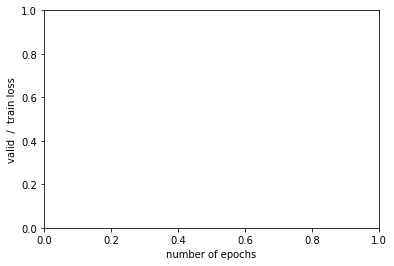

In [14]:
fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)

plt.show()

### Test the model

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\alexanet.ckpt')

### Confusion Matrix

In [15]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [16]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9674
accuracy 0.9674


True

In [17]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)

In [18]:
stacked[9].tolist()

[9, 9]

In [19]:
cmt = torch.zeros(10,10, dtype=torch.int64)

In [20]:
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1

In [21]:
cmt

tensor([[ 963,    0,    2,    2,    0,    5,    6,    1,    0,    1],
        [   1, 1110,    1,    1,    0,    2,    6,    3,   11,    0],
        [   4,    6, 1011,    4,    0,    0,    2,    3,    1,    1],
        [   1,    2,    2,  990,    0,    5,    0,    4,    2,    4],
        [   1,    5,    1,    0,  930,    0,    3,    5,    4,   33],
        [   2,    0,    0,   18,    0,  866,    3,    0,    2,    1],
        [   7,    1,    1,    3,    2,    4,  939,    0,    1,    0],
        [   0,    2,   17,    1,    0,    0,    0,  999,    1,    8],
        [   8,    0,   13,   15,    1,   19,    8,    1,  903,    6],
        [   3,    3,    2,    6,   13,    7,    0,   12,    0,  963]])

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [23]:
lb = test_dataset.targets.detach().cpu().numpy()

In [24]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [25]:
cm = confusion_matrix(lb, rp)

Confusion matrix, without normalization
[[ 963    0    2    2    0    5    6    1    0    1]
 [   1 1110    1    1    0    2    6    3   11    0]
 [   4    6 1011    4    0    0    2    3    1    1]
 [   1    2    2  990    0    5    0    4    2    4]
 [   1    5    1    0  930    0    3    5    4   33]
 [   2    0    0   18    0  866    3    0    2    1]
 [   7    1    1    3    2    4  939    0    1    0]
 [   0    2   17    1    0    0    0  999    1    8]
 [   8    0   13   15    1   19    8    1  903    6]
 [   3    3    2    6   13    7    0   12    0  963]]


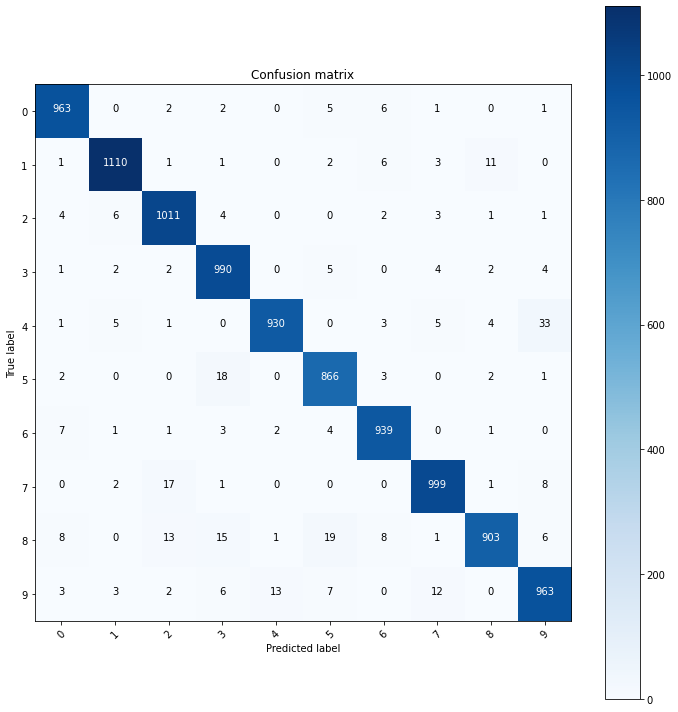

In [26]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

### Image

In [31]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.to(device)
            output = model(data)
            
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
#                 print(wrong_samples[i].shape)
                sample = sample.to(device)
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                path = '.\\mistakes\\alexanet\\'
                img.save(path+'wrong_idx{}_pred{}_actual{}.png'.format(
                    wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [32]:
test(model,device, test_loader)